#  2.	Perform Stacking Ensemble analysis on the Boston Housing Data set. 
You can use Python, Weka, KNIME or other tool to perform Stacking or write your own version in Python code. Include interesting plots and attribute importance analysis to support the choice of the final model configuration chosen.  Any combination of any of the Machine learning algorithms we have covered in the class so far or you are already familiar with is acceptable to be used in the Stacking Ensemble.

In [1]:
%pylab inline
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

Populating the interactive namespace from numpy and matplotlib


In [2]:
link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
col=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','PRICE']
df=pd.read_fwf(link,names=col)
df.to_csv(path_or_buf='Boston_Housing_Data', sep=',', na_rep='')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
#check for NAN and check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
PRICE      506 non-null float64
dtypes: float64(12), int64(2)
memory usage: 55.4 KB


In [4]:
# Import and Normalize Data
scaler = MinMaxScaler()
X = scaler.fit_transform(df.ix[:,0:-1])
y = df.ix[:,-1]

data_x1, data_final, target_x1, target_final = train_test_split(X, y, test_size=0.03, random_state=42)

In [5]:
data_train, data_test, target_train, target_test = train_test_split(data_x1, target_x1, test_size=0.33, random_state=42)

# Stack Ensemble - Round 0 

Decided to use KNeighbors Regrossor , Random Forest and Gradient Bossting:

# Reasons For Using Specific Regressors

#### 1) KNN Regressor - 
It works on arbitrarily nonlinear data
It works in an arbitrary number of dimensions without substantive changes. 

#### 2) Random Forest- 
Random Forest will have a high accuracy on train data but risks overfitting

#### 3) Gradient Boosting- 
Gradient Boost will be resistant to overfit but has lower accuracy on train compared to Random Forest

In [6]:
def round0(data,target):
    '''Train classifiers of Stack0'''
    
    classifiers = [KNeighborsRegressor(n_neighbors=2),
                   RandomForestRegressor(n_estimators=20, warm_start=True),
                   GradientBoostingRegressor(n_estimators=100, warm_start=True)]
    
    columns=['KNeighborsRegressor', 'Random_Forest','Gradient_Boosting']
    
    stack0={}
    clfs = {}
    score = {}

    data_train, data_test, target_train, target_test = train_test_split(data_x1, target_x1, test_size=0.2, random_state=42)

    
    for clf,col in zip(classifiers,columns):  
        clf.fit(data_train,target_train)
        pred = clf.predict(data_test)
        score = clf.score(data_test, target_test)
        stack0[col]=pred
        clfs[col]=clf
        print col, "Overall Score: ", score
    
    stack0['PRICE'] = target_test
    stack0_df = pd.DataFrame(stack0)
    return stack0_df, clfs

round0 = round0(data_train, data_test)
round0[0].head()

KNeighborsRegressor Overall Score:  0.782411008421
Random_Forest Overall Score:  0.879061056995
Gradient_Boosting Overall Score:  0.897028849148


,Gradient_Boosting,KNeighborsRegressor,PRICE,Random_Forest
48,17.461504,16.55,14.4,19.020
86,20.128144,21.95,22.5,20.800
498,20.689611,20.05,21.2,21.205
99,33.740985,28.55,33.2,33.725
315,20.486838,20.70,16.2,19.955


# Use Round 1 Stack and Linear Regressor to Predict Full Stacking Ensemble 
### The model was fit on training and test, while the final scores are run on Final Data

In [11]:
def clf_MultiStack (data_final, target_final):
    
    # Setup Classifier 1 which is based off of the training data
    classify_1 = round0[1].values()

    #Specifies types of regressors used in setup clf above
    columns=['KNeighborsRegressor', 'Random_Forest','Gradient_Boosting']

    #creates dataframe to add predictions to
    new_df=pd.DataFrame()
    x=2
    for i in classify_1:
        predict = i.predict(data_test)
        new_df[columns[x]]=round0[1][columns[x]].predict(data_final)
        x-=1

    #Setup Linear Regressor to estimate the weighting for each regression method
    stack_data = round0[0].iloc[:, [0,1,3]]
    stack_target=round0[0].iloc[:, [2]]
    linear_clf = linear_model.LinearRegression()
    Classify_2 = linear_clf.fit(stack_data, stack_target)

    #Use the Linear Regressor to Predict Final Predictions
    Final_Predict = pd.DataFrame(Classify_2.predict(new_df), columns=['Labels'])

    #Predict
    Ensemble_Accuracy = Classify_2.score(new_df, target_final)
    print "The Resulting Ensemble Accuracy is:" , Ensemble_Accuracy
    return Final_Predict

clf_MultiStack (data_final, target_final)


The Resulting Ensemble Accuracy is: 0.883127244868


,Labels
0,24.259002
1,32.159244
2,14.746071
3,23.083671
4,15.811903
5,21.127356
6,18.068063
7,12.907692
8,20.253760
9,20.012117


In [10]:
Final_Predict=clf_MultiStack (data_final, target_final)

The Resulting Ensemble Accuracy is: 0.883127244868


# The Resulting Ensemble Accuracy is: 89% in comparison with lower individual scores
FYI: Others ran the data on itself which produced higher accuracy, but that way is not the correct way of doing it

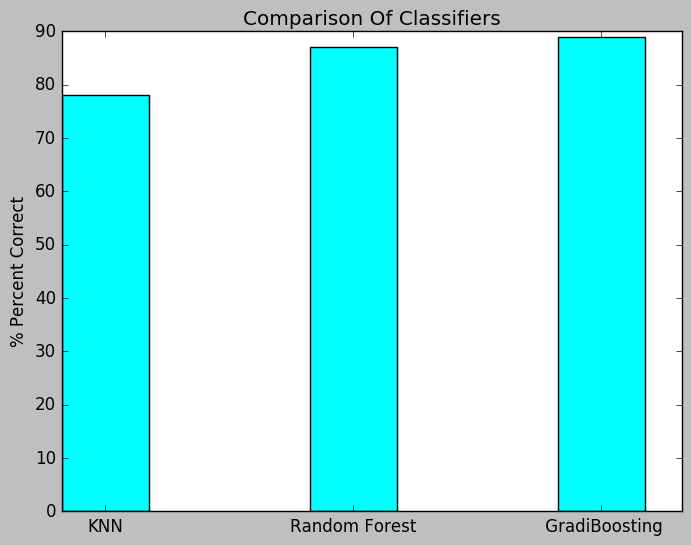

In [34]:
n=len(month)
kitchen=np.array([78, 87, 89])


ind=np.arange(n)
width=0.35

p1=plt.bar(ind,kitchen,width,color="cyan")


plt.ylabel("% Percent Correct")
plt.title("Comparison Of Classifiers")
plt.xticks(ind+width/2,("KNN","Random Forest"," GradiBoosting"))
plt.show()

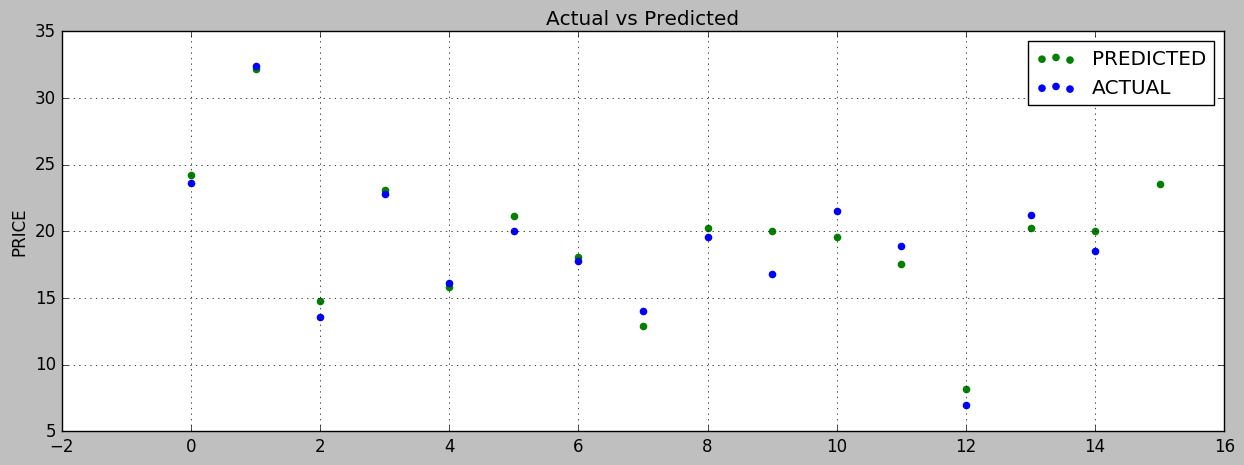

In [35]:


plt.figure(figsize=(15,5))

#Actual vs Predicted
plt.scatter(range(len(Final_Predict)),Final_Predict,color='green')
plt.scatter(range(len(target_final)),target_final, color='blue')
plt.title('Actual vs Predicted')
plt.ylabel('PRICE')
plt.legend(['PREDICTED','ACTUAL'], loc=0)

plt.grid()



In [13]:
Final_Predict=clf_MultiStack (data_final, target_final)
Final_Predict

The Resulting Ensemble Accuracy is: 0.883127244868


,Labels
0,24.259002
1,32.159244
2,14.746071
3,23.083671
4,15.811903
5,21.127356
6,18.068063
7,12.907692
8,20.253760
9,20.012117


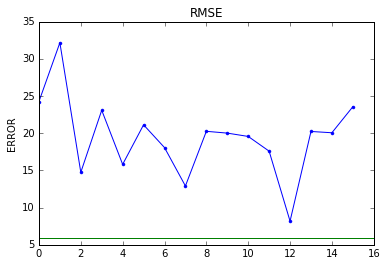

In [14]:
#Mean Squared Error
plt.plot(abs(Final_Predict), '.-')
plt.axhline(y=np.std(target_final), color='green')
plt.title('RMSE')
plt.ylabel('ERROR')
